In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle

from tardis import calculate_euclidicity

external_path=''

In [5]:
for digit in range(10):
    if digit==0:
        latents=torch.load(f'{external_path}\\latent_activations\\{digit}.pt').detach().numpy()
        labels=digit*np.ones(latents.shape[0])
    else:
        digit_latents=torch.load(f'{external_path}\\latent_activations\\{digit}.pt').detach().numpy()
        latents=np.concatenate((latents,digit_latents))
        labels=np.concatenate((labels,digit*np.ones(digit_latents.shape[0])))

C:\Users\thoma\AppData\Local\Temp\ipykernel_17276\2503856116.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latents=torch.load(f'{external_path}\\latent_activations\\{d

In [6]:
latents_mean = np.mean(latents, axis=0)
latents_centred = latents - latents_mean

covariance_matrix = np.cov(latents_centred, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

principal_components = eigenvectors_sorted[:, :2]
latents_reduced = np.dot(latents_centred, principal_components)

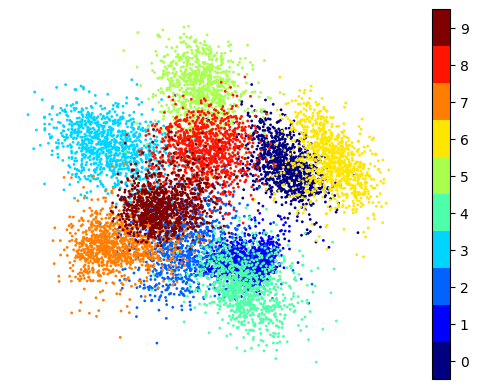

In [7]:
fig,axs=plt.subplots(nrows=1,ncols=1)
colors=plt.get_cmap('jet',10)
sp=axs.scatter(latents_reduced[:,0],latents_reduced[:,1],c=labels,cmap=colors,s=1)
cbar=fig.colorbar(sp)
cbar.ax.set_yticks(0.9*np.arange(10)+0.45)
cbar.ax.set_yticklabels(range(10))
axs.axis('off')
plt.show()

In [ ]:
model=TSNE(n_components=2)
transformed_latents=model.fit_transform(latents)

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=1)
colors=plt.get_cmap('jet',10)
sp=axs.scatter(transformed_latents[:,0],transformed_latents[:,1],c=labels,cmap=colors,s=1)
cbar=fig.colorbar(sp)
cbar.ax.set_yticks(0.9*np.arange(10)+0.45)
cbar.ax.set_yticklabels(range(10))
axs.axis('off')
plt.show()

In [ ]:
correctly_classified_indices_file=open(f'{external_path}\\correctly_classified_test_indices','rb')
correctly_classified_indices=pickle.load(correctly_classified_indices_file)
correctly_classified_indices_file.close()

def get_boundary_points(digit):
    starting_idx=sum([len(correctly_classified_indices[n]) for n in range(digit)])
    idxs=[]
    for other_digit in range(10):
        if digit==other_digit:
            continue
        pairs=np.load(f'{external_path}\\boundary_info\\pairs\\{digit}_{other_digit}.npy')
        idxs+=[starting_idx+pair[0] for pair in pairs]
    return np.array(list(set(idxs)))

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=1)
colors=plt.cm.jet([0.2,0.8])
concept_boundary_points=np.concatenate([get_boundary_points(k) for k in range(10)])
axs.scatter(transformed_latents[:,0],transformed_latents[:,1],color=colors[0],s=1)
axs.scatter(transformed_latents[concept_boundary_points,0],transformed_latents[concept_boundary_points,1],color=colors[1],s=2)
axs.axis('off')
plt.show()

In [ ]:
k_euclidicity=40
euclidicity = calculate_euclidicity(latents,max_dim=10,n_steps=5,k=k_euclidicity)
np.save(f'{external_path}\\cluster_info\\euclidicity_{k_euclidicity}.npy',euclidicity)

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=1)
sp=axs.scatter(transformed_latents[:,0],transformed_latents[:,1],c=euclidicity/np.max(euclidicity),cmap='jet',s=1,vmin=0)
cbar=fig.colorbar(sp)
axs.axis('off')
plt.show()

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=1)
sp=axs.scatter(transformed_latents[concept_boundary_points,0],transformed_latents[concept_boundary_points,1],c=euclidicity[concept_boundary_points]/np.max(euclidicity),cmap='jet',s=2,vmin=0)
cbar=fig.colorbar(sp)
axs.axis('off')
plt.show()

In [ ]:
from scipy.stats import pearsonr

euclidicity/=np.max(euclidicity)

def get_boundary_interior_mean(positive_digit,negative_digit,euclidicity):
    pairs=np.load(f'{external_path}\\boundary_info\\pairs\\{positive_digit}_{negative_digit}.npy')
    positive_starting_idx=sum([len(correctly_classified_indices[n]) for n in range(positive_digit)])
    negative_starting_idx=sum([len(correctly_classified_indices[n]) for n in range(negative_digit)])

    positive_ending_idx=sum([len(correctly_classified_indices[n]) for n in range(positive_digit+1)])
    negative_ending_idx=sum([len(correctly_classified_indices[n]) for n in range(negative_digit+1)])

    positive_idxs=np.array([pair[0] for pair in pairs])
    negative_idxs=np.array([pair[1] for pair in pairs])

    euclidicities_positive=euclidicity[positive_starting_idx:positive_ending_idx]
    euclidicities_negative=euclidicity[negative_starting_idx:negative_ending_idx]

    positive_boundary_mean=np.mean(euclidicities_positive[positive_idxs])
    negative_boundary_mean=np.mean(euclidicities_negative[negative_idxs])

    positive_interior_mean=(sum(euclidicities_positive)-sum(euclidicities_positive[positive_idxs]))/(len(euclidicities_positive)-len(positive_idxs))
    negative_interior_mean=(sum(euclidicities_negative)-sum(euclidicities_negative[negative_idxs]))/(len(euclidicities_negative)-len(negative_idxs))

    return positive_interior_mean,positive_boundary_mean,negative_interior_mean,negative_boundary_mean



difference_pbm_pim=[]
difference_pim_nim=[]
difference_pbm_nbm=[]
target_gradient_cav=[]
target_gradient_cbv=[]

for positive_digit in range(10):
    max_grad_cav=0
    max_grad_cbv=0
    euclidicity_summary={'concept':[],'negative_interior_mean':[],'negative_boundary_mean':[],'positive_interior_mean':[],'positive_boundary_mean':[],'target_gradients_cav_mean':[],'target_gradients_cbv_mean':[]}
    for negative_digit in range(10):
        if positive_digit==negative_digit:
            continue
        euclidicity_summary['concept']+=[negative_digit]
        
        pim,pbm,nim,nbm=get_boundary_interior_mean(positive_digit,negative_digit,euclidicity)

        euclidicity_summary['negative_interior_mean'].append(nim)
        euclidicity_summary['negative_boundary_mean'].append(nbm)
        euclidicity_summary['positive_interior_mean'].append(pim)
        euclidicity_summary['positive_boundary_mean'].append(pbm)

        gradients_cav=np.load(f'{external_path}\\cluster_info\\gradients_on_target_cav\\{positive_digit}_{negative_digit}.npy')
        gradients_cbv=np.load(f'{external_path}\\cluster_info\\gradients_on_target_cbv\\{positive_digit}_{negative_digit}.npy')
        euclidicity_summary['target_gradients_cav_mean'].append(np.mean(gradients_cav))
        euclidicity_summary['target_gradients_cbv_mean'].append(np.mean(gradients_cbv))
        
        max_grad_cav=max(max_grad_cav,np.mean(gradients_cav))
        max_grad_cbv=max(max_grad_cbv,np.mean(gradients_cbv))
    
    colors=plt.cm.jet([0,0.2,0.8,1])
    fig,axs=plt.subplots(nrows=1,ncols=1)
    plotting_digits=np.array([dig for dig in range(10) if dig!=positive_digit])
    axs.bar(plotting_digits-0.2,euclidicity_summary['positive_interior_mean'],width=0.1,label='Positive Interior Mean',color=colors[0])
    axs.bar(plotting_digits-0.1,euclidicity_summary['positive_boundary_mean'],width=0.1,label='Positive Boundary Mean',color=colors[1])
    axs.bar(plotting_digits+0.1,euclidicity_summary['negative_interior_mean'],width=0.1,label='Negative Interior Mean',color=colors[2])
    axs.bar(plotting_digits+0.2,euclidicity_summary['negative_boundary_mean'],width=0.1,label='Negative Boundary Mean',color=colors[3])
    axs.set_xticks(plotting_digits,euclidicity_summary['concept'])
    axs.legend(ncols=4,bbox_to_anchor=(1.06,1.06),fontsize=6)
    fig.savefig(f'{external_path}\\cluster_info\\interior_boundary_mean_plots\\{positive_digit}.png',bbox_inches='tight')
    plt.close()

    difference_pbm_pim+=[np.abs(pbm-pim) for pbm,pim in zip(euclidicity_summary['positive_boundary_mean'],euclidicity_summary['positive_interior_mean'])]
    difference_pim_nim+=[np.abs(pim-nim) for pim,nim in zip(euclidicity_summary['positive_interior_mean'],euclidicity_summary['negative_interior_mean'])]
    difference_pbm_nbm+=[np.abs(pim-nim) for pim,nim in zip(euclidicity_summary['positive_boundary_mean'],euclidicity_summary['negative_boundary_mean'])]
    target_gradient_cav+=[grad/max_grad_cav for grad in euclidicity_summary['target_gradients_cav_mean']]
    target_gradient_cbv+=[grad/max_grad_cbv for grad in euclidicity_summary['target_gradients_cbv_mean']]

fig,axs=plt.subplots(nrows=1,ncols=3)
colors=plt.cm.jet([0,0.1,0.9,1])
fig.set_figwidth(12)
fig.set_figheight(4)
pbm_pim_cav_cor,pbm_pim_cav_pvalue=pearsonr(difference_pbm_pim,target_gradient_cav,alternative='less')
pbm_pim_cbv_cor,pbm_pim_cbv_pvalue=pearsonr(difference_pbm_pim,target_gradient_cbv,alternative='less')
a_cav,b_cav=np.polyfit(difference_pbm_pim,target_gradient_cav,deg=1)
a_cbv,b_cbv=np.polyfit(difference_pbm_pim,target_gradient_cbv,deg=1)
axs[0].plot(difference_pbm_pim,a_cav*np.array(difference_pbm_pim)+b_cav,color=colors[1])
axs[0].plot(difference_pbm_pim,a_cbv*np.array(difference_pbm_pim)+b_cbv,color=colors[2])
axs[0].scatter(difference_pbm_pim,target_gradient_cav,label='CAV',color=colors[0])
axs[0].scatter(difference_pbm_pim,target_gradient_cbv,label='CBV',color=colors[3])
axs[0].set_ylabel('Mean Gradient at Target Logit')
axs[0].set_xlabel('Difference in Positive Boundary Interior Euclidicity Means',fontsize=8)
axs[0].set_title(f'CAV: Cor Coef {pbm_pim_cav_cor:.3f}, p-Value {pbm_pim_cav_pvalue:.3f}\nCBV: Cor Coef {pbm_pim_cbv_cor:.3f}, p-Value {pbm_pim_cbv_pvalue:.3f}')

pim_nim_cav_cor,pim_nim_cav_pvalue=pearsonr(difference_pim_nim,target_gradient_cav,alternative='less')
pim_nim_cbv_cor,pim_nim_cbv_pvalue=pearsonr(difference_pim_nim,target_gradient_cbv,alternative='less')
a_cav,b_cav=np.polyfit(difference_pim_nim,target_gradient_cav,deg=1)
a_cbv,b_cbv=np.polyfit(difference_pim_nim,target_gradient_cbv,deg=1)
axs[1].plot(difference_pim_nim,a_cav*np.array(difference_pim_nim)+b_cav,color=colors[1])
axs[1].plot(difference_pim_nim,a_cbv*np.array(difference_pim_nim)+b_cbv,color=colors[2])
axs[1].scatter(difference_pim_nim,target_gradient_cav,label='CAV',color=colors[0])
axs[1].scatter(difference_pim_nim,target_gradient_cbv,label='CBV',color=colors[3])
axs[1].set_xlabel('Difference in Interior Euclidicity Means',fontsize=8)
axs[1].set_title(f'CAV: Cor Coef {pim_nim_cav_cor:.3f}, p-Value {pim_nim_cav_pvalue:.3f}\nCBV: Cor Coef {pim_nim_cbv_cor:.3f}, p-Value {pim_nim_cbv_pvalue:.3f}')

pbm_nbm_cav_cor,pbm_nbm_cav_pvalue=pearsonr(difference_pbm_nbm,target_gradient_cav,alternative='less')
pbm_nbm_cbv_cor,pbm_nbm_cbv_pvalue=pearsonr(difference_pbm_nbm,target_gradient_cbv,alternative='less')
a_cav,b_cav=np.polyfit(difference_pbm_nbm,target_gradient_cav,deg=1)
a_cbv,b_cbv=np.polyfit(difference_pbm_nbm,target_gradient_cbv,deg=1)
axs[2].plot(difference_pbm_nbm,a_cav*np.array(difference_pbm_nbm)+b_cav,color=colors[1])
axs[2].plot(difference_pbm_nbm,a_cbv*np.array(difference_pbm_nbm)+b_cbv,color=colors[2])
axs[2].scatter(difference_pbm_nbm,target_gradient_cav,label='CAV',color=colors[0])
axs[2].scatter(difference_pbm_nbm,target_gradient_cbv,label='CBV',color=colors[3])
axs[2].set_xlabel('Difference in Boundary Euclidicity Means',fontsize=8)
axs[2].set_title(f'CAV: Cor Coef {pbm_nbm_cav_cor:.3f}, p-Value {pbm_nbm_cav_pvalue:.3f}\nCBV: Cor Coef {pbm_nbm_cbv_cor:.3f}, p-Value {pbm_nbm_cbv_pvalue:.3f}')
axs[2].legend()

fig.savefig(f'{external_path}\\cluster_info\\difference_in_means_avg_target_gradient_plot.png')
plt.close()